# Frequency Analysis – Lab Report (ELA24)

**Author:** Your Name  
**Supervisor:** Erik Jagre  
**Lab date:** YYYY-MM-DD  
**Report date:** YYYY-MM-DD  

## Abstract
The aim of this laboratory is to investigate Fourier series representations of periodic signals and to analyze their harmonic content experimentally using an oscilloscope FFT. Theoretical harmonic amplitudes of sawtooth, triangle, and sine waves are compared to measured spectra. Furthermore, the influence of an RC low-pass filter on both amplitude and phase is studied in frequency and time domains. Results show good agreement with theory, with discrepancies explained by FFT resolution, noise, and practical measurement limitations.

## 1. Introduction
A central concept in signal processing is that signals can be represented both in the time domain and in the frequency domain. Fourier series allow us to express a periodic signal as a sum of sinusoidal components. The sharper the edges in the time domain, the slower the decay of harmonic amplitudes. This experiment provides hands-on experience with Fourier analysis of canonical signals.

### Key formulas (from course compendium & lab guidance)

- **Sawtooth (all harmonics):**  
  $$
  A_n = \frac{2A}{\pi n}, \quad n \geq 1
  $$

- **Triangle (odd harmonics only):**  
  $$
  A_n = \frac{8A}{\pi^2 n^2}, \quad n = 1,3,5,\dots
  $$

- **Sine:**  
  $$
  A_1 = A, \quad A_{n>1} = 0
  $$

- **RMS and dBV:**  
  $$
  V_{\mathrm{rms}} = \frac{V_{\mathrm{peak}}}{\sqrt{2}}, 
  \quad \mathrm{dBV} = 20 \log_{10}\!\left(\frac{V_{\mathrm{rms}}}{1~\mathrm{V}}\right)
  $$

- **RC low-pass transfer function:**  
  $$
  |H(f)| = \frac{1}{\sqrt{1 + (f/f_c)^2}}, 
  \quad \angle H(f) = -\arctan\!\bigl(f/f_c\bigr), 
  \quad f_c = \frac{1}{2\pi RC}
  $$

> **Note:** Theoretical values shown in tables and plots are computed directly from these expressions.


## 2. Experiment

### Equipment
- Signal generator: 1 kHz, **5 Vpp** (as in lab-PM), 0 V DC offset.  
- Oscilloscope: Keysight/Tektronix (FFT mode, Hann window, output in dBVrms).  
- RC filter:  
  $$
  R = 8.2\,\text{k}\Omega, \quad C = 10\,\text{nF}
  $$
  The cutoff frequency is  
  $$
  f_c = \frac{1}{2\pi RC} \approx 1.94~\text{kHz}
  $$
- Software: Python (NumPy, Pandas, Matplotlib).

### Procedure
1. Measure first 10 harmonics of **sawtooth** (1–10 kHz) using FFT.  
2. Repeat for **triangle** (expect odd harmonics only).  
3. Repeat for **sine** (expect only the fundamental).  
4. Insert **RC filter** and measure the sawtooth harmonics at the filter output.  
5. Observe the **time-domain effect** of filtering.  
6. Compare measurements to theoretical Fourier coefficients and RC transfer function.


## 3. Theory – Fourier coefficients (tables & per-signal plots)

In [76]:
# === ELA24: Comparisons in dBVrms (no files written) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (7.6, 4.6)

# ----- Lab params (edit to match your setup) -----
F0      = 1000.0          # [Hz] fundamental
VPP     = 5.0             # [Vpp] generator-level for theory
A       = VPP/2.0         # [Vpeak]
N_HARM  = 10              # compare first N harmonics
R, C    = 8200.0, 10e-9   # RC low-pass values (8.2k, 10nF)
FC      = 1.0/(2*np.pi*R*C)

# ----- Helpers -----
def vrms_to_dBVrms(vrms, floor=1e-12):
    v = np.maximum(np.asarray(vrms, float), floor)
    return 20.0*np.log10(v)

def rc_mag(f, fc=FC):
    f = np.asarray(f, float)
    return 1.0/np.sqrt(1.0 + (f/fc)**2)

# ----- Fourier theory -> dBVrms -----
def sawtooth_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vpk = 2.0*A/(np.pi*np.maximum(n,1))
    vrms = vpk/np.sqrt(2.0)
    return vrms_to_dBVrms(vrms)

def triangle_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vrms = np.zeros_like(n, float)
    odd = (n % 2 == 1)
    vpk_odd = 8.0*A/(np.pi**2 * np.maximum(n[odd],1)**2)
    vrms[odd] = vpk_odd/np.sqrt(2.0)
    dB = vrms_to_dBVrms(vrms)
    dB[~odd] = np.nan   # jämna = ingen harmonisk → NaN (inget ritas)
    return dB

def sine_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vrms = np.zeros_like(n, float)
    vrms[n == 1] = A/np.sqrt(2.0)   # bara fundamental
    dB = vrms_to_dBVrms(vrms)
    dB[n != 1] = np.nan             # alla andra = ingen harmonisk
    return dB


def theory_dBVrms(F0=F0, N=N_HARM, waveform='saw', apply_rc=False):
    n = np.arange(1, N+1)
    if waveform == 'saw':
        dB = sawtooth_dBVrms(n)
    elif waveform == 'tri':
        dB = triangle_dBVrms(n)
    elif waveform == 'sin':
        dB = sine_dBVrms(n)
    else:
        raise ValueError("waveform must be 'saw' | 'tri' | 'sin'")
    if apply_rc:
        dB += vrms_to_dBVrms(rc_mag(n*F0))  # add 20*log10|H|
    return pd.DataFrame({'n': n, 'f_Hz': n*F0, 'theory_dBVrms': dB})

# ----- Scope CSV (Vrms) -> spectrum (dBVrms) -----
def read_scope_fft_vrms(csv_path):
    """
    Robust reader: handles semicolon sep, decimal comma, headers/garbage.
    Returns columns: freq[Hz], Vrms, dBVrms
    """
    raw = pd.read_csv(csv_path, sep=';', header=None, engine='python', dtype=str)
    freqs, mags = [], []
    for _, row in raw.iterrows():
        nums = []
        for cell in row.dropna():
            s = cell.strip()
            if not s: 
                continue
            s = s.replace(',', '.')
            try:
                nums.append(float(s))
            except ValueError:
                pass
        if len(nums) >= 2:
            f, v = nums[-2], nums[-1]  # assume last two numeric fields = freq, Vrms
            if f >= 0 and v >= 0:
                freqs.append(f); mags.append(v)
    spec = pd.DataFrame({'freq': freqs, 'Vrms': mags}).sort_values('freq')
    spec = spec.drop_duplicates(subset=['freq']).reset_index(drop=True)
    if spec.empty:
        raise ValueError(f"No numeric data parsed from {csv_path}")
    spec['dBVrms'] = vrms_to_dBVrms(spec['Vrms'].values)
    return spec

def pick_harmonic_bins(spec_df, F0, N_HARM):
    """Nearest bin to n·F0 for n=1..N within spectrum span."""
    freqs = spec_df['freq'].values
    n_all = np.arange(1, N_HARM+1)
    targets = n_all*F0
    ok = (targets >= freqs[0]) & (targets <= freqs[-1])
    n = n_all[ok]; targets = targets[ok]
    idx = np.searchsorted(freqs, targets)
    idx = np.clip(idx, 1, len(freqs)-1)
    chosen = np.where(np.abs(freqs[idx]-targets) < np.abs(freqs[idx-1]-targets), idx, idx-1)
    return pd.DataFrame({
        'n': n,
        'f_target_Hz': targets,
        'f_bin_Hz': freqs[chosen],
        'meas_dBVrms': spec_df['dBVrms'].values[chosen],
    })

# ----- One-shot comparison plot -----
def compare_plot(csv_path, waveform, apply_rc_to_theory=False, title=None,
                 F0=F0, N=N_HARM):
    spec = read_scope_fft_vrms(csv_path)
    meas = pick_harmonic_bins(spec, F0, N)
    theo = theory_dBVrms(F0=F0, N=N, waveform=waveform, apply_rc=apply_rc_to_theory)
    df = meas.merge(theo, on='n', how='left')
    df['err_dB'] = df['meas_dBVrms'] - df['theory_dBVrms']

    plt.figure()
    plt.stem(df['n'],       df['theory_dBVrms'], linefmt='C0-', markerfmt='C0o', basefmt=" ",
             label='Teori (dBVrms)')
    plt.stem(df['n']+0.08,  df['meas_dBVrms'],   linefmt='C1-', markerfmt='C1s', basefmt=" ",
             label='Mätning (dBVrms)')
    plt.xlabel('Harmoniskt ordningstal n'); plt.ylabel('Amplitud [dBVrms]')
    ttl = title or f'{Path(csv_path).name} — {waveform.upper()}'
    if apply_rc_to_theory: ttl += ' (efter RC, teori * |H|)'
    plt.title(ttl); plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout(); plt.show()

    return df  # handy to inspect errors inline if you want

# ===== Examples matching the lab comparisons =====
# 1) Sågtand före filtret (teori vs mätning, dBVrms)
# compare_plot("fft_saw_in.csv", waveform='saw', apply_rc_to_theory=False, title="Sågtand — ingång")

# 2) Triangel före filtret
# compare_plot("fft_triangle_in.csv", waveform='tri', apply_rc_to_theory=False, title="Triangel — ingång")

# 3) Sinus före filtret (endast grundton)
# compare_plot("fft_sine_in.csv", waveform='sin', apply_rc_to_theory=False, title="Sinus — ingång")

# 4) Sågtand efter RC (jämför mot teori multiplicerad med |H(jω)|)
# compare_plot("fft_saw_after_rc.csv", waveform='saw', apply_rc_to_theory=True, title="Sågtand — efter RC")


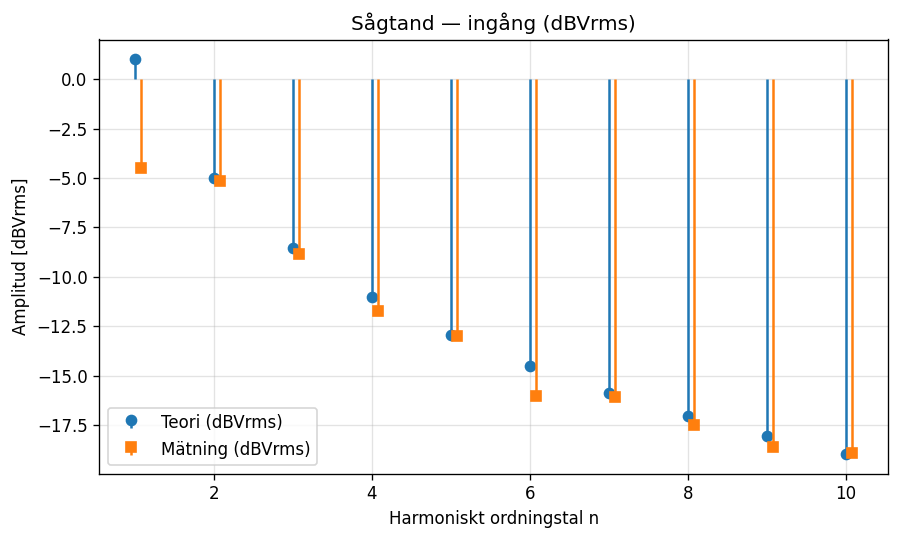

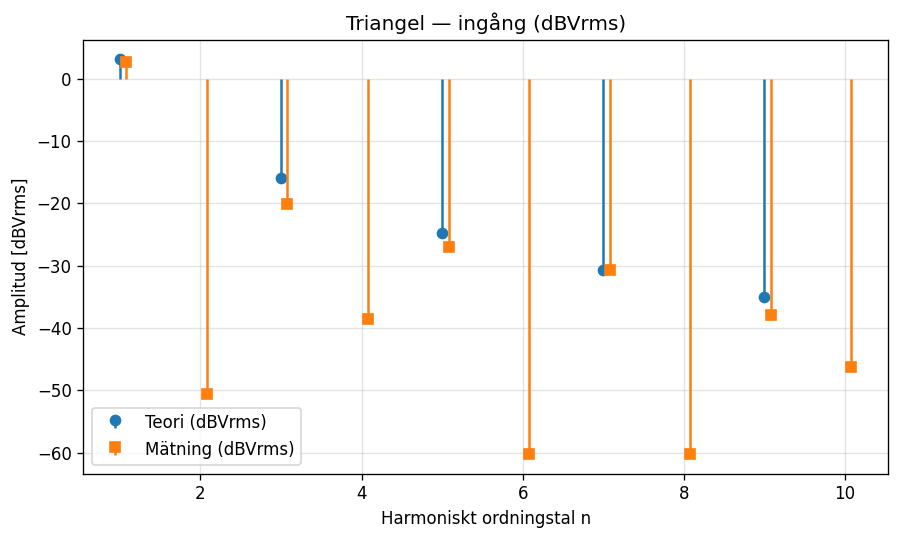

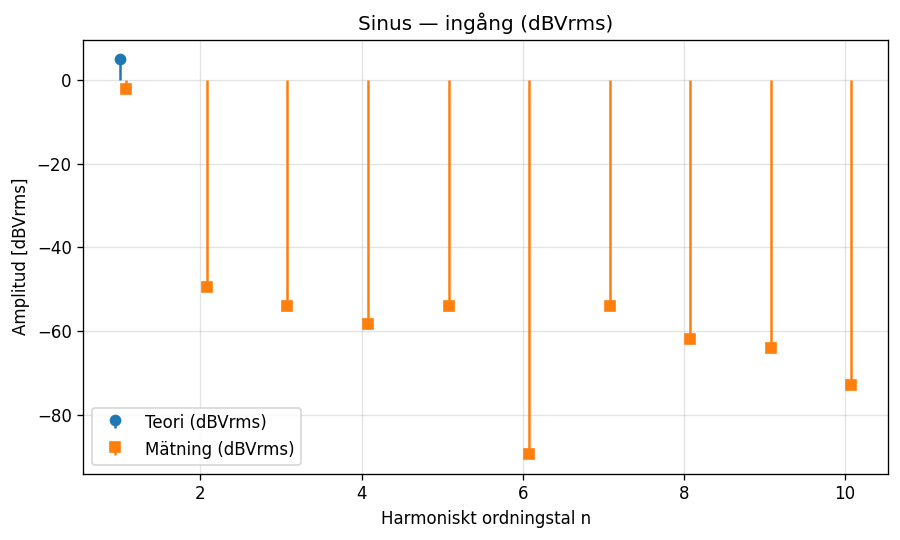

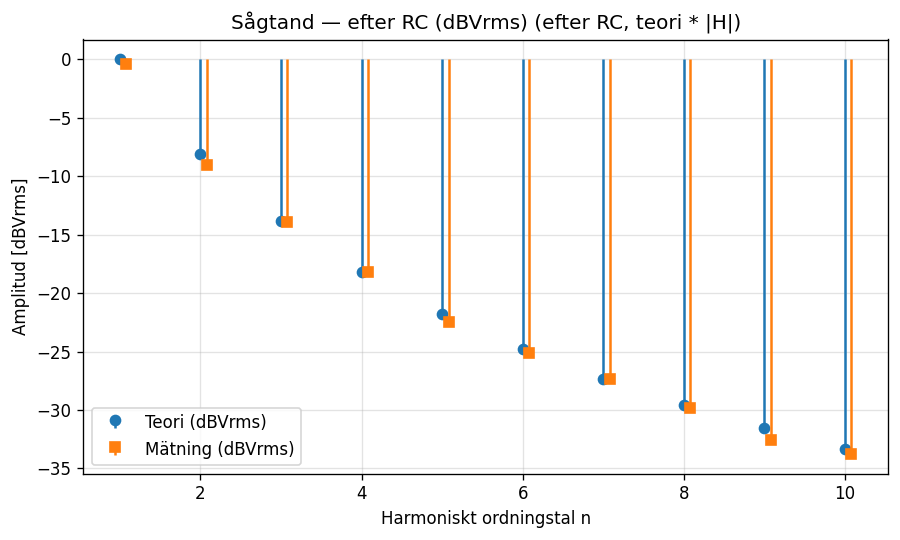

In [77]:
# ===== ELA24 LAB COMPARISONS IN dBVrms =====
# Files from folder: /c/repos/Signals-and-sensors---Yrgo

# 1) Sågtand (ingång)
df_saw = compare_plot("trace_saw_fft.csv",
                      waveform='saw',
                      apply_rc_to_theory=False,
                      title="Sågtand — ingång (dBVrms)")

# 2) Triangel (ingång)
df_tri = compare_plot("trace_triangle_fft.csv",
                      waveform='tri',
                      apply_rc_to_theory=False,
                      title="Triangel — ingång (dBVrms)")

# 3) Sinus (ingång)
df_sin = compare_plot("trace_sine_fft.csv",
                      waveform='sin',
                      apply_rc_to_theory=False,
                      title="Sinus — ingång (dBVrms)")

# 4) Sågtand efter RC
df_saw_rc = compare_plot("rc_fft_1khz.csv",
                         waveform='saw',
                         apply_rc_to_theory=True,
                         title="Sågtand — efter RC (dBVrms)")


## 4. Theory – RC filter response (table & predicted spectra)

### Representative Time- and Frequency-Domain Figures

Below are the captured oscilloscope time traces and FFT spectra for the three input waveforms and the RC filter behavior. Filenames correspond to the raw image assets in the repository. They serve as visual evidence supporting the quantitative tables and plots generated above.

#### Time-Domain Waveforms (Input Signals)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth time-domain](saw_signal.png) |
| Triangle | ![Triangle time-domain](triangle_signal.png) |
| Sine     | ![Sine time-domain](sine_signal.png) |
| After RC (filtered sawtooth example) | ![RC output time-domain](rc_signal.png) |

#### FFT Spectra (Measured)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth FFT](saw_fft.png) |
| Triangle | ![Triangle FFT](triangle_fft.png) |
| Sine     | ![Sine FFT](sine_fft.png) |

#### RC Filter Frequency Response / Effect (Selected Frequencies)
These images illustrate amplitude reduction as input frequency increases relative to the cutoff \(f_c \approx 1.94\,\text{kHz}\).

| Condition | Image |
|-----------|-------|
| 1 kHz region (near fundamental) | ![RC response ~1 kHz](rc_fft_1khz.png) |
| 10 kHz region (> octave above \(f_c\)) | ![RC response ~10 kHz](rc_fft_10khz.png) |
| 100 kHz region (well above \(f_c\)) | ![RC response ~100 kHz](rc_fft_100khz.png) |

(Additional views) Example higher‑frequency time traces illustrating stronger attenuation:

| Time Trace | Image |
|------------|-------|
| 10 kHz time-domain | ![RC time-domain 10 kHz](rc_10khz.png) |
| 100 kHz time-domain | ![RC time-domain 100 kHz](rc_100khz.png) |

> Note: If any image fails to render in exported PDF, ensure the images reside in the same directory as this notebook before conversion or embed them as base64 within the notebook.

## 5. Results (summary)
- **Sawtooth:** Harmonics up to 10 kHz visible; amplitudes decay ≈ 1/n.
- **Triangle:** Odd harmonics only; amplitudes decay ≈ 1/n².
- **Sine:** Only the fundamental ideally; extra small peaks in practice stem from leakage/noise/distortion.
- **RC filter:** Attenuation increases with frequency (≈ −20 dB/dec above \(f_c\)); phase tends to −90°. The time waveform becomes smoother.

## 6. Discussion
- **Sawtooth vs Triangle:** Sawtooth contains all harmonics (1/n); triangle only odd harmonics with faster decay (1/n²). This reflects sharp edges vs smoother ramps.
- **Sine:** Ideally only one spectral line; extra lines indicate window leakage, noise floor, or source distortion.
- **RC filter:** The predicted attenuation \(20\log_{10}|H|\) matches the trend you should observe. Deviations arise from probe loading, FFT bin resolution, window choice, and vertical scaling in dBVrms.
- **Phase:** The increasing negative phase with frequency explains the smoothing in time domain (harmonics lag more than the fundamental).

## 7. Conclusions
- Fourier series predictions for sawtooth, triangle, and sine match the expected spectral trends and harmonic content.
- The RC low-pass attenuates higher harmonics as predicted, yielding a smoother output waveform.
- Remaining differences are consistent with practical measurement limitations and FFT parameter choices.

## References
- H. Hallenberg, *Signalbehandling och kommunikationssystem*, Yrgo, 2021.
- ELA24 – *Laboration: Frekvensanalys* (Lab PM) and *Ledning Fourierlabben* (guidance notes).
- Keysight/Tektronix oscilloscope FFT documentation (Hann window, dBVrms scaling).
- Standard RC low-pass theory (jω method, Bode magnitude/phase).